# Interactive Plotting of Seismic Data Amplitude Spectrum
## Taking Fourier Transform to plot amplitude spectrum of 1D/2D/3D post-stack seismic data in sgy/segy format 
### Author: Amir Abbas Babasafari (AB) 
### Date: April 2024
### Email: a.babasafari@yahoo.com
### IDE: Jupyter Notebook
### Python version: 3.9

### *Please make sure that data loaded is post-stack seismic data, pre-stack is not supported
### *Supported Data Format: 4-byte IBM float and 4-byte IEEE float

#####

### Hint: In the Kernel menu, select 'Restart kernel and run all cells' if using the default values, otherwise you may specify smooth_factor and trace_skip_number in the following cells.

#####

### Import Libraries
#### Please run the cell below

In [1]:
import os
import sys
import numpy as np
import segyio 
from matplotlib import pyplot as plt
from tkinter import *
from tkinter import filedialog
import ipywidgets as widgets
from ipywidgets import interact

### Load a sgy/segy file

#### Please run the cell below, click on 'open a file' button on pop-up window to select your seismic data in segy/sgy format, followed by clicking on the 'close the window' button.

In [2]:
def load_segy_file():
    '''
    Function to load a segy file
    
    Return file path of loaded segy file
    '''
    
    global filepath
    
    # Open file name
    file = filedialog.askopenfilename(initialdir = os.getcwd(),
    title = "Please select 2D/3D post-stack seismic data in segy format",
    filetypes = [('sgy files','*.sgy'),('segy files','*.segy'),('All files','*.*')])
    filepath = file
    print("File_path: {0}".format(filepath))
    
# Create root window
root = Tk()
root.geometry('300x200')  
root.title('AB')

# Open button to click in a GUI toolkit
open_button1 = Button(root, text = "Open a File", command = load_segy_file)
open_button2 = Button(root, text = "Close the Window", command = root.destroy)
open_button1.pack()
open_button2.pack()

# Run the application
root.mainloop()

File_path: E:/AB_2023/Visualization/Data for test plus bri data/seismic_segy/Seismic_open_data/3D-Waipuku.sgy


## Read 1D/2D/3D post-stack seismic data, identify seismic data parameters, and calculate amplitude spectrum
#### Please run the cell below

In [3]:
def calculate_mean_amplitude_spectrum(filepath, kernel_length, skip_no):
    """   
    Function to read, identify seismic data parameters, and calculate amplitude spectrum
    
    Parameter:
    ----------
    filepath (str): file path of loaded segy file
    kernel_length (int): smoothing factor for plotting amplitude spectrum
    skip_no (int): number of traces to skip for calculating amplitude spectrum
    
    Returns:
    --------
    interpolated_frequency_axis (numpy.ndarray): Frequency axis of amplitude spectrum upto nyquist frequency in HZ
    normalized_mean_spectrum (numpy.ndarray): Normalized mean amplitude spectrum 
    amplitude_spectrum (numpy.ndarray): Normalized amplitude spectrum per selected seismic trace

    Author: Amir Abbas Babasafari (AB)
    """
    
    # Read segy data and identify data parameters
    try:
        with segyio.open(filepath, ignore_geometry=True) as f:
            # Get the attributes
            n_traces = f.tracecount
            # sample rate = 2 ms or 4 ms
            sample_rate = segyio.tools.dt(f) / 1000
            n_samples = f.samples.size
            twt = f.samples
            seismic_data = f.trace.raw[:].T 
            spec = segyio.spec()
            data_format = f.format
            # print(f.bin)
            print("Seismic data parameters: \n Total number of traces: {0}, Every {1} traces, Number of samples per trace: {2}, \n \
            Sample rate: {3}ms, Trace length: {4}ms, Data format: {5}" .format(n_traces, skip_no, n_samples, sample_rate, max(twt) - min(twt), data_format))

    except:
        print("Error, seismic data was not loaded successfully, this could happen due to unsupported data format") 
        print("Data format 4-byte IBM float and 4-byte IEEE float are supported")
        print('In addition, please check that data loaded is post-stack seismic data, pre-stack is not supported')

    
    if seismic_data.shape[1] > 1 and seismic_data.shape[1] > skip_no: 
        traces = seismic_data[:,::skip_no]
    else:
        traces = seismic_data
    
        
    # Define sample rate and nyquist frequency
    sample_rate = sample_rate * 1e-3
    nyquist_frequency = int(1 / (2 * sample_rate))

    # Initialize list of zero trace index    
    zero_trace_index = [] 
    
    # Calculate zero trace index and exclude zero traces from seismic data
    for ind in range(traces.shape[1]):
        if np.any(traces[:,ind]) == 0.0 or np.any(traces[:,ind]) == None:
            zero_trace_index.append(ind)
    traces = np.delete(traces, zero_trace_index, 1)
    
    # Initialize amplitude based on nyquist frequency
    amplitude_spectrum_for_mean = np.empty(shape=(nyquist_frequency, traces.shape[1]))
    amplitude_spectrum = np.empty(shape=(nyquist_frequency, traces.shape[1]))

    # Calculate amplitude spectrum using fourier transform
    for i in range(traces.shape[1]):

        n_sample = len(traces[:,i])
        spectrum = np.fft.fft(traces[:,i] / n_sample)
        frequency = np.fft.fftfreq(n_sample)
        
        # Display positive frequency content with corresponding absolute and real amplitude
        spectrum_real = abs(spectrum[:int(n_sample / 2)].real)
        # scale frequency axis wih Nyquist frequency for positive axis only
        frequency_axis = frequency[:int(n_sample / 2)] * (1 / sample_rate)

        # Interpolate spectrum_real and freq_axis
        interpolated_frequency_axis = np.arange(0, nyquist_frequency, 1)
        interpolated_spectrum_real = np.interp(interpolated_frequency_axis, frequency_axis, spectrum_real)

        # Smooth the amplitude spectrum if needed
        kernel = np.ones(kernel_length) / kernel_length
        smooth_spectrum = np.convolve(interpolated_spectrum_real, kernel, mode='same')

        amplitude_spectrum_for_mean[:,i] = smooth_spectrum

        # Normalize the amplitude spectrum 
        normalized_spectrum = (smooth_spectrum-min(smooth_spectrum))\
        /(max(smooth_spectrum)-min(smooth_spectrum))

        amplitude_spectrum[:,i] = normalized_spectrum

    # Calculate average of amplitude spectrum for all selected traces
    mean_spectrum = np.mean(amplitude_spectrum_for_mean, axis=1) 
    # Normalize the average amplitude spectrum 
    normalized_mean_spectrum = (mean_spectrum-min(mean_spectrum))/(max(mean_spectrum)-min(mean_spectrum))
    
    
    return interpolated_frequency_axis, normalized_mean_spectrum, amplitude_spectrum

## Plot amplitude spectrum
#### Please run the cell below

In [4]:
def plot_amplitude_spectrum(spectrum, mode='mean'):    
    '''
    Function to plot amplitude spectrum 
    '''
    
    if mode == 'mean':
        cmap = 'orange'
        lbl = 'mean amplitude spectrum'
    else:
        cmap = 'blue'
        lbl = 'amplitude spectrum'

    plt.plot(interpolated_frequency_axis, spectrum, color = cmap, \
             label = lbl, linestyle='solid', linewidth = 3)
    plt.xlabel('Frequency (HZ)')
    plt.ylabel('Normalized Amplitude')
    plt.title("Amplitude Spectrum upto Nyquist Frequency \n Seismic file name: {0}".format(os.path.splitext(os.path.basename(filepath))[0]))
    plt.legend()
    plt.grid(True)
    plt.show()

####

### Please specify parameters below or use the default values and run the cells below

In [5]:
# smoothing factor for plotting amplitude spectrum
smooth_factor = 2

# number of traces to skip for calculating amplitude spectrum
trace_skip_number = 2000

# calculate amplitude spectrum
interpolated_frequency_axis, normalized_mean_spectrum, seismic_amplitude_spectrum = calculate_mean_amplitude_spectrum(filepath, kernel_length = smooth_factor, skip_no = trace_skip_number)

Seismic data parameters: 
 Total number of traces: 46176, Every 2000 traces, Number of samples per trace: 2001, 
             Sample rate: 2.0ms, Trace length: 4000.0ms, Data format: 4-byte IBM float


### Interactive Plotting of the Amplitude Spectrum for the Selected Seismic Traces
#### Please run the cell below

In [8]:
traces = np.arange(seismic_amplitude_spectrum.shape[1])
mid = int(seismic_amplitude_spectrum.shape[1]/2)
@interact(trace=widgets.IntSlider(min=traces[0], max=traces[-1], step=1, value=mid))

def interactive_amplitude_spectrum(trace):    
    plot_amplitude_spectrum(seismic_amplitude_spectrum[:,trace], mode='interactive')


interactive(children=(IntSlider(value=9, description='trace', max=17), Output()), _dom_classes=('widget-intera…

### Plot Mean Amplitude Spectrum
#### Please run the cell below

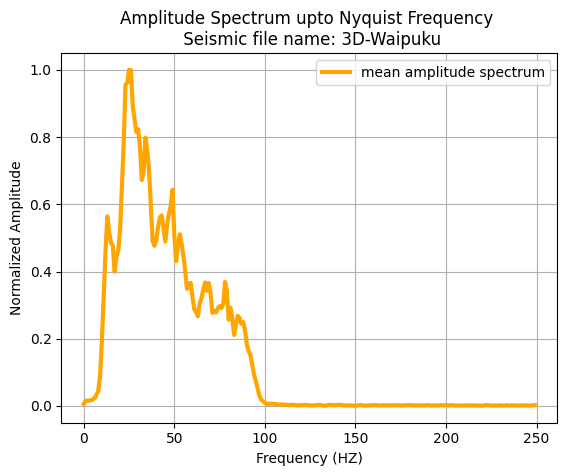

In [7]:
plot_amplitude_spectrum(normalized_mean_spectrum, mode='mean')    

### Thank you for your attention

##### AB